In [197]:
import regex as re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ezzaldeen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [134]:
with open("cbow_corp_001.txt", encoding="utf-8") as file:
    corpus = file.read()
    
# sample of the corpus
corpus[5000:6000]

'author’s works; and for this contention\nin such narrow space as is permitted to me, I propose here to show\ncause._\n\n_In the first place, the book (it may be barely necessary to remind the\nreader) was in its first shape written very early, somewhere about 1796,\nwhen Miss Austen was barely twenty-one; though it was revised and\nfinished at Chawton some fifteen years later, and was not published till\n1813, only four years before her death. I do not know whether, in this\ncombination of the fresh and vigorous projection of youth, and the\ncritical revision of middle life, there may be traced the distinct\nsuperiority in point of construction, which, as it seems to me, it\npossesses over all the others. The plot, though not elaborate, is almost\nregular enough for Fielding; hardly a character, hardly an incident\ncould be retrenched without loss to the story. The elopement of Lydia\nand Wickham is not, like that of Crawford and Mrs. Rushworth, a_ coup de\nthéâtre; _it connects itsel

In [145]:
def tokenize(corpus):
    # simple tokenizer
    pattern = re.compile(r'[A-Za-z]+')
    tokens = pattern.findall(corpus.lower())
    # stop words removal
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    return tokens

# tokenize the corpus
tokens = tokenize(corpus)
# vocabulary (set of unique words)
vocab = set(tokens)
# vocabulary size
vocab_size = len(vocab)

id2token = {i: t for i, t in enumerate(vocab)}
token2id = {t: i for i, t in enumerate(vocab)}

def encode(token, token2id):
    # create a one-hot vector
    idx = token2id[token]
    vector = [0] * vocab_size
    vector[idx] = 1
    return np.array(vector)


print("vocab size:", vocab_size)

vocab size: 6847


```text
    objective:
        based on the given context try to predict the center word,
        training the neural net on this objective going to build
        a word representaion (word embeddings) hopefully.

    preparing the training data:
        [0, 0, 1, 0, ..., 0] -> 'context word(i-2)'
        [0, 1, 0, 0, ..., 0] -> 'context word(i-1)'
        [1, 0, 0, 0, ..., 0] -> 'context word(i+1)'
        [0, 0, 0, 0, ..., 1] -> 'context word(i+2)'

        compined vectors:
        [1, 1, 1, 1, ..., 1] -> 'context words' # this is going to be the input

        center word:
        [0, 0, 0, 0, ..., 0] -> 'center word' # to be predicted

        NOTE: values in vectors just for demo

```

In [146]:
def build_data(tokens, window_size=2):
    # training data consists of 
    # context words and center words
    # where the model learns to predict
    # the center word from the context words
    contexts = []
    centers = []
    for i in range(len(tokens)):
        # context per current center word
        # to save the context words and combine them
        # into single vector per center word
        context = []
        for j in range(max(0, i-window_size), min(len(tokens), i+window_size+1)):
            if i != j:
                # encode context word
                context.append(encode(tokens[j], token2id))
        # encode center word
        centers.append(encode(tokens[i], token2id))
        # combine context words into single vector
        contexts.append(np.sum(context, axis=0))
        
    return np.array(contexts), np.array(centers)

In [147]:
# build the training data
contexts, centers = build_data(tokens)
print("contexts:", contexts.shape)
print("centers:", centers.shape)

contexts: (59796, 6847)
centers: (59796, 6847)


In [148]:
class CBOWModel:
    def __init__(self, vocab_size, embedding_size):
        # Xavier initialization
        limit = np.sqrt(6.0 / (vocab_size + embedding_size))
        self.w1 = np.random.uniform(-limit, limit, size=(vocab_size, embedding_size))
        self.w2 = np.random.uniform(-limit, limit, size=(embedding_size, vocab_size))
        assert self.w1.shape[1] == self.w2.shape[0]

    def train(self, contexts, centers, epochs=3, batch_size=64, lr=0.025, verbose=False):
        losses = []
        num_steps = len(contexts) // batch_size
        for epoch in range(epochs):
            loss = 0
            for step, batch in enumerate(range(0, len(contexts), batch_size)):
                # batches
                ctx_batch = contexts[batch:batch+batch_size]
                cnt_batch = centers[batch:batch+batch_size]
                # forward pass
                self._forward(ctx_batch)
                # softmax activation 
                predictions = self._softmax(self.a2)
                # backward pass
                self._backward(cnt_batch, predictions, ctx_batch, lr)
                # compute loss
                assert predictions.shape == cnt_batch.shape
                loss += self._cross_entropy(cnt_batch, predictions)
                if verbose:
                    print(f"step: {step:03d}/{num_steps} -- loss: {loss:03f}")

            losses.append(loss)
            print(f"epoch: {epoch:03d}/{epochs} -- loss: {loss:03f}")

        return losses

    def _forward(self, contexts):
        assert contexts.shape[1] == self.w1.shape[0]
        self.a1 = np.dot(contexts, self.w1) # out shape: (N, embed_size)
        assert self.a1.shape[1] == self.w2.shape[0]
        self.a2 = np.dot(self.a1, self.w2) # out shape: (N, vocab)

    def _backward(self, actual, predictions, contexts, lr):
        loss_grad = predictions - actual
        # derivative W2
        w2_grad = np.dot(self.a1.T, loss_grad)
        # derivative W1
        w1_grad = np.dot(contexts.T, np.dot(loss_grad, self.w2.T))
        # shape validation
        assert w2_grad.shape == self.w2.shape
        assert w1_grad.shape == self.w1.shape
        # update weights
        self.w1 -= lr * w1_grad
        self.w2 -= lr * w2_grad

    def _softmax(self, a):
        # for numerical stability
        # avoide numerical overflow
        a = a - np.max(a, axis=1, keepdims=True)
        exp_a = np.exp(a)
        return exp_a / np.sum(exp_a, axis=1, keepdims=True)
        
    def _cross_entropy(self, actual, prediction, epsilon=1e-10):
        prediction = np.clip(prediction, epsilon, 1 - epsilon)
        num_samples = actual.shape[0]
        return -1 * np.sum(actual * np.log(prediction)) / num_samples

EMBEDDING SIZE: 2
epoch: 000/5 -- loss: 512.869051
epoch: 001/5 -- loss: 461.628149
epoch: 002/5 -- loss: 446.572330
epoch: 003/5 -- loss: 441.757816
epoch: 004/5 -- loss: 438.951600
EMBEDDING SIZE: 10
epoch: 000/5 -- loss: 509.627338
epoch: 001/5 -- loss: 458.784568
epoch: 002/5 -- loss: 443.859422
epoch: 003/5 -- loss: 436.483692
epoch: 004/5 -- loss: 431.090323
EMBEDDING SIZE: 50
epoch: 000/5 -- loss: 505.828673
epoch: 001/5 -- loss: 455.995010
epoch: 002/5 -- loss: 440.050227
epoch: 003/5 -- loss: 431.028906
epoch: 004/5 -- loss: 422.066761
EMBEDDING SIZE: 100
epoch: 000/5 -- loss: 503.373291
epoch: 001/5 -- loss: 454.116693
epoch: 002/5 -- loss: 439.033649
epoch: 003/5 -- loss: 429.252362
epoch: 004/5 -- loss: 419.432054
EMBEDDING SIZE: 150
epoch: 000/5 -- loss: 501.338379
epoch: 001/5 -- loss: 452.493406
epoch: 002/5 -- loss: 437.687626
epoch: 003/5 -- loss: 426.473102
epoch: 004/5 -- loss: 415.156895


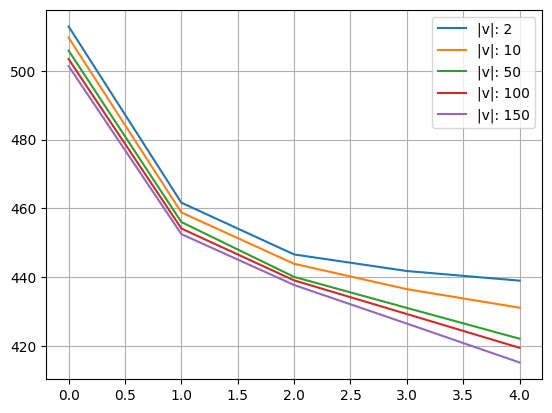

In [171]:
np.random.seed(42)

embed_sizes = [2, 10, 50, 100, 150]

models = {}
for embed_size in embed_sizes:
    print(f"EMBEDDING SIZE: {embed_size}")
    model = CBOWModel(vocab_size, embed_size)
    history = model.train(contexts, centers, epochs=5, batch_size=1024, lr=0.015)
    plt.plot([i for i in range(len(history))], history, label=f"|v|: {embed_size}")
    models[embed_size] = model

plt.legend()
plt.grid()
plt.show()

In [172]:
def get_relevant_words(w, model):
    token_id = token2id[w]
    similarites = np.dot(model.w1, model.w1[token_id])
    most_similar = np.argsort(similarites)[::-1][:10]
    
    for i, tid in enumerate(most_similar):
        print(f"word #{i}: {id2token[tid]}")

In [176]:
get_relevant_words("bingley", models[150])

word #0: bingley
word #1: darcy
word #2: austen
word #3: collins
word #4: gardiner
word #5: bennet
word #6: hurst
word #7: wickham
word #8: bennets
word #9: lucas


Turn out the model could capture the similarities between the charachters in the novel (Pride & Prejudice).

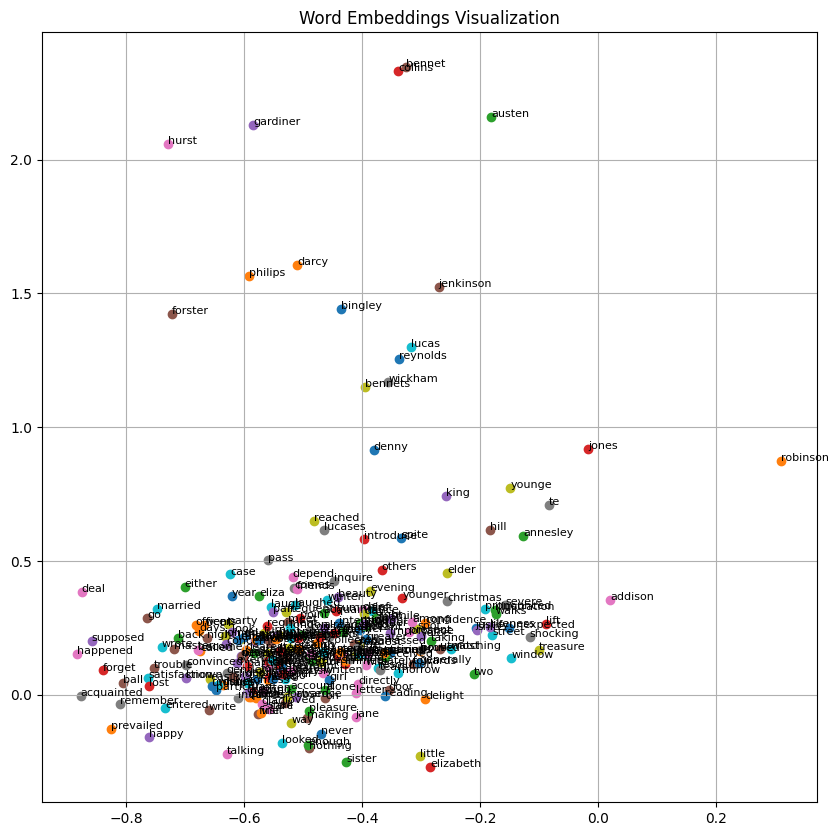

In [241]:
def get_similar_tokens(word, embeddings):
    token_id = token2id[word]
    similarites = np.dot(embeddings, embeddings[token_id])
    # most similar token ids
    token_ids = np.argsort(similarites)[::-1][:250]
    return token_ids

def visualize_similar_words(embeddings, word, id2token):
    # getting mose similar words
    token_ids = get_similar_tokens(word, embeddings)
    # perform PCA to reduce dimensionality to 2 dimensions
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    # plot the embeddings
    plt.figure(figsize=(10, 10))
    for tkn_id in token_ids:
        word = id2token[tkn_id]
        plt.scatter(embeddings_2d[tkn_id, 0], embeddings_2d[tkn_id, 1])
        plt.text(embeddings_2d[tkn_id, 0], embeddings_2d[tkn_id, 1], word, fontsize=8)
    
    plt.title('Word Embeddings Visualization')
    plt.grid(True)
    plt.show()

model_150d = models[150]
visualize_similar_words(model_150d.w1, 'bingley', id2token)